In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected
from sklearn.manifold import TSNE

Matplotlib is building the font cache; this may take a moment.


In [6]:
dataset_folder = "data/"

# 1. Load edge data (Recipe–Ingredient)
r_i_src, r_i_dst, r_i_weight = torch.load(
    os.path.join(dataset_folder, "edge_r2i_src_dst_weight.pt")
)

# 2. Load edge data (Recipe–Recipe)
r_r_src, r_r_dst, r_r_weight = torch.load(
    os.path.join(dataset_folder, "edge_r2r_src_and_dst_and_weight.pt")
)

# 3. Load edge data (Ingredient–Ingredient)
i_i_src, i_i_dst, i_i_weight = torch.load(
    os.path.join(dataset_folder, "edge_i2i_src_and_dst_and_weight.pt")
)

# 4. Load edge data (User–Recipe)
all_u2r_src_dst_weight = torch.load(
    os.path.join(dataset_folder, "all_train_val_test_edge_u_rate_r_src_and_dst_and_weight.pt")
)
all_u2r_src, all_u2r_dst, all_u2r_weight = all_u2r_src_dst_weight[0]

# 5. Load node data (Recipe/Ingredient)
recipe_instr_features = torch.load(
    os.path.join(dataset_folder, "recipe_nodes_avg_instruction_features.pt")
)
ingredient_nutrient_features = torch.load(
    os.path.join(dataset_folder, "ingredient_nodes_nutrient_features.pt")
)

In [7]:
data = HeteroData()

# Convert lists to tensors if necessary
all_u2r_src = torch.tensor(all_u2r_src, dtype=torch.long)
all_u2r_dst = torch.tensor(all_u2r_dst, dtype=torch.long)
all_u2r_weight = torch.tensor(all_u2r_weight, dtype=torch.float)

r_i_src = torch.tensor(r_i_src, dtype=torch.long)
r_i_dst = torch.tensor(r_i_dst, dtype=torch.long)
r_i_weight = torch.tensor(r_i_weight, dtype=torch.float)

r_r_src = torch.tensor(r_r_src, dtype=torch.long)
r_r_dst = torch.tensor(r_r_dst, dtype=torch.long)
r_r_weight = torch.tensor(r_r_weight, dtype=torch.float)

i_i_src = torch.tensor(i_i_src, dtype=torch.long)
i_i_dst = torch.tensor(i_i_dst, dtype=torch.long)
i_i_weight = torch.tensor(i_i_weight, dtype=torch.float)

# NODES:
# We often need to define the number of nodes per type.
# For example, from your logs:
num_users = 7959
num_recipes = 68794
num_ingredients = 8847

data["user"].num_nodes = num_users
data["recipe"].num_nodes = num_recipes
data["ingredient"].num_nodes = num_ingredients

# EDGES:
# user -> recipe
data["user", "u-r", "recipe"].edge_index = torch.stack([all_u2r_src, all_u2r_dst], dim=0)
data["user", "u-r", "recipe"].edge_weight = all_u2r_weight

# recipe -> ingredient
data["recipe", "r-i", "ingredient"].edge_index = torch.stack([r_i_src, r_i_dst], dim=0)
data["recipe", "r-i", "ingredient"].edge_weight = r_i_weight

# recipe -> recipe
data["recipe", "r-r", "recipe"].edge_index = torch.stack([r_r_src, r_r_dst], dim=0)
data["recipe", "r-r", "recipe"].edge_weight = r_r_weight

# ingredient -> ingredient
data["ingredient", "i-i", "ingredient"].edge_index = torch.stack([i_i_src, i_i_dst], dim=0)
data["ingredient", "i-i", "ingredient"].edge_weight = i_i_weight

# If you want to make the graph fully bidirectional:
data = ToUndirected()(data)

# recipe_instr_features: [68794, feature_dim_recipe]
# ingredient_nutrient_features: [8847, feature_dim_ingr]
data["recipe"].x = recipe_instr_features
data["ingredient"].x = ingredient_nutrient_features

# Suppose we use random user features, e.g., shape [7959, 300]:
#user_feat = torch.rand(num_users, 300)
#data["user"].x = user_feat

In [14]:
for node_type in data.node_types:
    print(f"{node_type} has {data[node_type].num_nodes} nodes, x shape = {data[node_type].x.shape if 'x' in data[node_type] else 'no features'}")

for edge_type in data.edge_types:
    edge_idx = data[edge_type].edge_index
    print(f"Edge type {edge_type} has {edge_idx.size(1)} edges, edge_weight shape = {data[edge_type].edge_weight.shape if 'edge_weight' in data[edge_type] else 'no weights'}")

user has 7959 nodes, x shape = no features
recipe has 68794 nodes, x shape = torch.Size([68794, 1024])
ingredient has 8847 nodes, x shape = torch.Size([8847, 46])
Edge type ('user', 'u-r', 'recipe') has 135353 edges, edge_weight shape = torch.Size([135353])
Edge type ('recipe', 'r-i', 'ingredient') has 463485 edges, edge_weight shape = torch.Size([463485])
Edge type ('recipe', 'r-r', 'recipe') has 647146 edges, edge_weight shape = torch.Size([647146])
Edge type ('ingredient', 'i-i', 'ingredient') has 146188 edges, edge_weight shape = torch.Size([146188])
Edge type ('recipe', 'rev_u-r', 'user') has 135353 edges, edge_weight shape = torch.Size([135353])
Edge type ('ingredient', 'rev_r-i', 'recipe') has 463485 edges, edge_weight shape = torch.Size([463485])


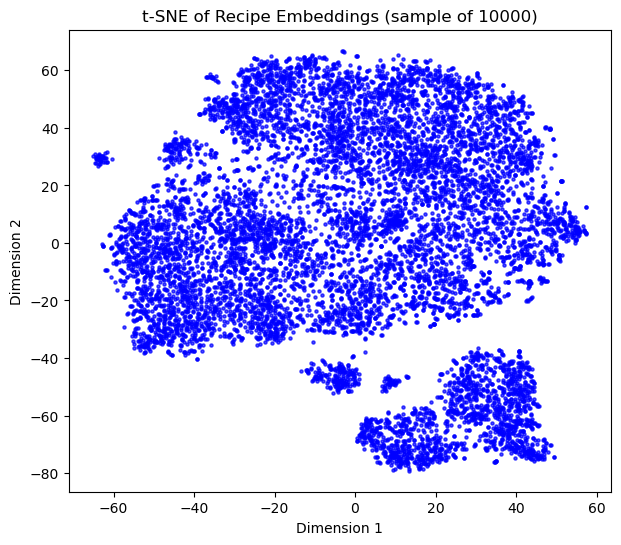

CPU times: user 1min 46s, sys: 4.93 s, total: 1min 51s
Wall time: 29 s


In [17]:
%%time
num_sample = 10000
indices = torch.randperm(num_recipes)[:num_sample]
sample_emb = data["recipe"].x[indices].detach().cpu().numpy()

# Perform TSNE in 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(sample_emb)

# Plot
plt.figure(figsize=(7,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=5, alpha=0.7, c="blue")
plt.title(f"t-SNE of Recipe Embeddings (sample of {num_sample})")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()